In [ ]:
import torch
import torch.nn as nn
import pandas as pd
from sklearn.datasets import make_circles


# Make 1000 samples 
n_samples = 1000

# Create circles
X, y = make_circles(n_samples,
                    noise=0.03, # a little bit of noise to the dots
                    random_state=42) # keep random state so we get the same values

#table view
circles = pd.DataFrame({"X1": X[:,0], "X2": X[:,1], "label": y})
print(circles.head(10))
circles.label.value_counts()

         X1        X2  label
0  0.754246  0.231481      1
1 -0.756159  0.153259      1
2 -0.815392  0.173282      1
3 -0.393731  0.692883      1
4  0.442208 -0.896723      0
5 -0.479646  0.676435      1
6 -0.013648  0.803349      1
7  0.771513  0.147760      1
8 -0.169322 -0.793456      1
9 -0.121486  1.021509      0


1    500
0    500
Name: label, dtype: int64

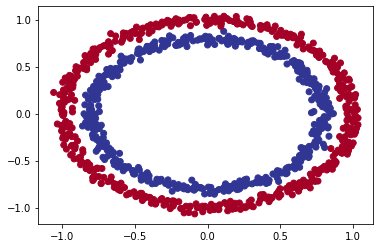

In [ ]:
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0], 
            y=X[:, 1], 
            c=y, 
            cmap=plt.cm.RdYlBu);

In [ ]:
# Turn data into tensors
# Otherwise this causes issues with computations later on
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

In [ ]:
#Split
from sklearn.model_selection import train_test_split
value_train, value_test, expect_train, expect_test = train_test_split(X, 
                                                    y, 
                                                    test_size=0.2, # 20% test, 80% train
                                                    random_state=42) # make the random split reproducible
print(len(value_train), len(value_test), len(expect_train), len(expect_test))

800 200 800 200


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [ ]:
#create module
class CircleModel(nn.Module):
  def __init__(self):
    super().__init__()
    #layers
    self.layer1 = nn.Linear(in_features = 2, out_features = 16)
    self.layer2 = nn.Linear(in_features = 16, out_features = 16)
    self.layer3 = nn.Linear(in_features = 16, out_features = 1)
    self.relu = nn.ReLU()

  def forward(self, x):
    return self.layer3(self.layer2(self.relu(self.layer1(x))))

model = CircleModel().to(device)
model

CircleModel(
  (layer1): Linear(in_features=2, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=16, bias=True)
  (layer3): Linear(in_features=16, out_features=1, bias=True)
  (relu): ReLU()
)

In [ ]:
#Loss Compile
loss_fn = nn.BCEWithLogitsLoss()

optimizer = torch.optim.SGD(params = model.parameters(), lr=0.1)

In [ ]:
#Visualize productivity
def accuracy(y_true, x_pred):
  corrects = torch.eq(y_true, x_pred).sum().item()
  accuracy = (corrects/len(x_pred))*100
  return accuracy

In [ ]:
#Sigmoid real boss?
y_logits = model(value_test.to(device))[:5]
print(y_logits)

y_pred_probs = torch.sigmoid(y_logits)
y_pred_probs

tensor([[0.0968],
        [0.0442],
        [0.2703],
        [0.0740],
        [0.2948]], device='cuda:0', grad_fn=<SliceBackward0>)


tensor([[0.5242],
        [0.5111],
        [0.5672],
        [0.5185],
        [0.5732]], device='cuda:0', grad_fn=<SigmoidBackward0>)

In [ ]:
# Find the predicted labels (round the prediction probabilities)
y_preds = torch.round(y_pred_probs)

# In full
y_pred_labels = torch.round(torch.sigmoid(model(value_test.to(device))[:5]))

# Check for equality
print(torch.eq(y_preds.squeeze(), y_pred_labels.squeeze()))

# Get rid of extra dimension
y_preds.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([1., 1., 1., 1., 1.], device='cuda:0', grad_fn=<SqueezeBackward0>)

In [ ]:
#Train
epochs = 1000
# Put data to target device
value_train, expect_train = value_train.to(device), expect_train.to(device)
value_test, expect_test = value_test.to(device), expect_test.to(device)
for epoch in range(epochs):
  model.train()

  #predict
  expect_logits = model(value_train).squeeze()
  expect_pred = torch.round(torch.sigmoid(expect_logits))

  #loss
  #nn.BCEWithLogitsLoss() works with logits
  loss = loss_fn(expect_logits, expect_train)
  acc = accuracy(expect_train, expect_pred)

  optimizer.zero_grad()
  loss.backward()
  optimizer.step()

  #Testing
  with torch.inference_mode():
    #predict
    test_logits = model(value_test).squeeze()
    test_pred = torch.round(torch.sigmoid(test_logits))

    #loss
    #nn.BCEWithLogitsLoss() works with logits
    test_loss = loss_fn(test_logits, expect_test)
    test_acc = accuracy(expect_test, test_pred)
    #print
    if epoch % 100 == 0:
      print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%")


Epoch: 0 | Loss: 0.70028, Accuracy: 50.62% | Test loss: 0.69484, Test acc: 53.50%
Epoch: 100 | Loss: 0.69000, Accuracy: 50.25% | Test loss: 0.68741, Test acc: 54.50%
Epoch: 200 | Loss: 0.68426, Accuracy: 57.50% | Test loss: 0.68317, Test acc: 58.50%
Epoch: 300 | Loss: 0.67488, Accuracy: 65.12% | Test loss: 0.67590, Test acc: 65.00%
Epoch: 400 | Loss: 0.65807, Accuracy: 67.38% | Test loss: 0.66253, Test acc: 63.00%
Epoch: 500 | Loss: 0.62753, Accuracy: 73.62% | Test loss: 0.63580, Test acc: 70.00%
Epoch: 600 | Loss: 0.56645, Accuracy: 89.12% | Test loss: 0.57724, Test acc: 88.00%
Epoch: 700 | Loss: 0.44521, Accuracy: 98.62% | Test loss: 0.46131, Test acc: 97.50%
Epoch: 800 | Loss: 0.28188, Accuracy: 99.88% | Test loss: 0.30982, Test acc: 99.00%
Epoch: 900 | Loss: 0.15571, Accuracy: 100.00% | Test loss: 0.18697, Test acc: 100.00%


In [ ]:
# #download help
# import requests
# from pathlib import Path 

# # Download helper functions from Learn PyTorch repo (if not already downloaded)
# if Path("helper_functions.py").is_file():
#   print("helper_functions.py already exists, skipping download")
# else:
#   print("Downloading helper_functions.py")
#   request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
#   with open("helper_functions.py", "wb") as f:
#     f.write(request.content)

# from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


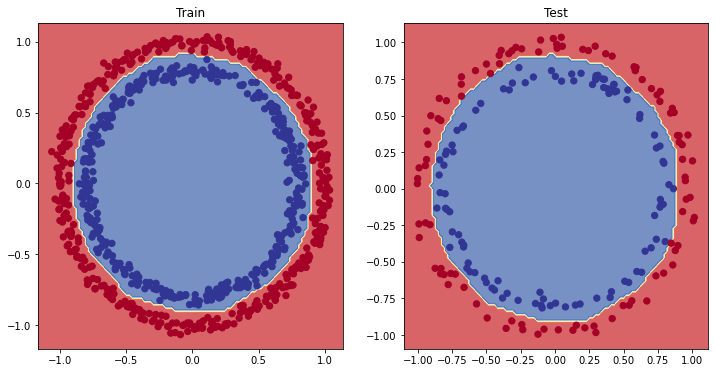

In [ ]:
# Plot decision boundaries for training and test sets
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model, value_train, expect_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model, value_test, expect_test)